The following cell will import WPTherml and set up a base structure that we will evaluate for selective thermal emission for solar thermophotovoltaic (STPV) applications.  For background information on STPV, a good (and open) review article can be found [here](https://cyberleninka.org/article/n/867899).

In [14]:
import wpspecdev
from matplotlib import pyplot as plt
import numpy as np

test_args = {
    "wavelength_list": [300e-9, 6000e-9, 1000],
    "Material_List": ["Air", "Al2O3", "SiO2", "TiO2", "SiO2", "Al2O3", "W", "Air"],
    "Thickness_List": [0, 20e-9, 255e-9, 150e-9, 255e-9, 10e-9, 900e-9, 0],
    "temperature": 1700,
    "therml": True
}



The following cell will define two helper functions that we will utilize in conjuction with WPTherml for the identification of Pareto-optimal selective emitters for STPV applications as discussed in [this paper](https://onlinelibrary.wiley.com/doi/abs/10.1002/aenm.201801035).  
In particular, we will model the top-most layer as an alloy of tungsten and aluminum oxide, and we will use the Maxwell-Garnet approximation for the effective permittivity $\epsilon_{eff}$ of this alloy:

$$ \epsilon_{eff} = \frac{\epsilon_D \left(2f \left(\epsilon_M - \epsilon_D \right) + \epsilon_M 2\epsilon_D \right)}{2 \epsilon_D + \epsilon_M + f \left(\epsilon_D - \epsilon_M \right)}, $$

where in this case we will treat $\epsilon_M$ as the permittivity of tungsten and $\epsilon_D$ as the permittivity aluminum oxide (each depending on frequency), and $f$ will be the volume fraction of tungsten in aluminum oxide.  The function `MaxwellGarnett()` will take the refractive index arrays that are associated with materials in WPTherml and a volume fraction as arguments and will return the refractive index of the alloy.  Note the refractive index $n$ can be defined from the permittivity $\epsilon$ as $n = \sqrt{\epsilon}$.

The function `is_dominated()` will take an array containing the STPV spectral efficiency $\eta$ and the STPV useful power density $\rho$ arising from the same set of structures and will identify all structures that are dominated by other structures.  This is essentially the complementary list of structures that are Pareto optimal; namely this will identify all structures that **do not** lie on the [Pareto front](https://en.wikipedia.org/wiki/Pareto_front).  Once we have identified the structures that are not on the Pareto front, we can use a single NumPy operation to define the set of structures that do.  

In [15]:
def MaxwellGarnett(ri_1, ri_2, fraction):
    """ a function that will compute the alloy refractive
    index between material_1 and material_2 using
    Maxwell-Garnett theory.  """
    # define _eps_d as ri_1 ** 2
    _eps_d = ri_1 * ri_1

    # define _eps_m as ri_2 * ri_2
    _eps_m = ri_2 * ri_2

    # numerator of the Maxwell-Garnett model
    _numerator = _eps_d * (2 * fraction * (_eps_m - _eps_d) + _eps_m + 2 * _eps_d)
    # denominator of the Maxwell-Garnett model
    _denominator = 2 * _eps_d + _eps_m + fraction * (_eps_d - _eps_m)

    # _numerator / _denominator is epsilon_effective, and we want n_eff = sqrt(epsilon_eff)
    return np.sqrt(_numerator / _denominator)

def is_dominated(eta, rho):
    '''Pareto optimal: structure x with useful power density \rho(x) and
       spectral efficiency \eta(x) is pareto optimal if for all y \neq x
       \rho(x) ≥ \rho(y) and \eta(x) ≥ \eta(y)
       and \rho(x) > \rho(y) or \eta(x) > \eta(y)'''
    _N = len(eta)
    _is_dominated = []
    for i in range(0, _N):
        _rho_x = rho[i]
        _eta_x = eta[i]
        for j in range(0, _N):
            if j != i:
                _rho_y = rho[j]
                _eta_y = eta[j]
                if _rho_y >= _rho_x and _eta_y >= _eta_x:
                    if _rho_y > _rho_x or _eta_y > _eta_x:
                        _is_dominated.append(i)
                        break
    return _is_dominated
                        
            
    

This block will create an instance of a multilayer structure called `test` that will have the STPV spectral efficiency and STPV useful power density associated with it as attributes.

In [16]:
sf = wpspecdev.SpectrumFactory()
test = sf.spectrum_factory('Tmm', test_args)

print(" STPV Spectral efficiency:", test.stpv_spectral_efficiency)
print(" STPV Power Density:", test.stpv_power_density)

 Your spectra have been computed! 😎 
 Your therml spectra have been computed! 🔥 
 STPV Spectral efficiency: 0.47964902513334884
 STPV Power Density: 27704.7560999668


In [17]:
# make this layer 70% W in alumina
n_eff = MaxwellGarnett(test._refractive_index_array[:,1], test._refractive_index_array[:,6], 0.75)
test._refractive_index_array[:,1] = n_eff

test.compute_stpv()
print(" STPV Spectral efficiency:", test.stpv_spectral_efficiency)
print(" STPV Power Density:", test.stpv_power_density)


 STPV Spectral efficiency: 0.6432743626385115
 STPV Power Density: 106023.70154558819


Now we will modify the thickness of the 3 layers between the top-most alloy layer and the bottom-most tungsten layer.  These 3 layers consist of SiO$_2$, TiO$_2$, and SiO$_2$ respectively. We will see that there is an incredible amount of flexibility in terms of the thermal emission spectra and the $\eta$ and $\rho$ figures of merit that can be realized by tuning the thickness of these 3 layers.  We could systematically vary the layer thicknesses in some range of reasonable thicknesses, or we could randomly select thicknesses in such a range.  In the cell below, we will randomly assign the thicknesses of each of the three layers 5000 times for a total of 5000 different instances of the emitter structure.  We will choose a random integer for each layer between 1 and 500 and scale it by 1e-9 so that we are effectly randomly choosing thicknesses between 1e-9 and 500e-9 m for each layer.  For each of these 5000 structures, we will compute and store the STPV spectral efficiency and power density for further analysis. 

In [18]:

n_layers = 3
N = 5000
thicknesses = np.random.randint(500, size=(N, n_layers))
solutions = np.zeros((N, n_layers+2))

solutions[:,:n_layers] = thicknesses

for i in range(0, N):
    test.thickness_array[2:5] = solutions[i,:3] * 1e-9
    test.compute_stpv()
    solutions[i,3] = test.stpv_spectral_efficiency
    solutions[i,4] = test.stpv_power_density
    

Now we will use the `is_dominated()` function to identify all of the solutions that are dominated by other solutions; the list of dominated solutions is *complementary* to the Pareto optimal solutions.  In particular, the `is_dominate()` function will look at the values of $\rho$ and $\eta$ stored in the `solutions` array and return the indices of all the entries of `solutions` that are dominated by at least one other entry in `solutions`.  Since the Pareto front is comprised only of solutions which are **not** dominated by any other solutions, we can identify the solutions on the Pareto front by deleting all of the solutions that are dominated by at least one other solution.  This deletion can be easily accomplished using `np.delete()` since we have the indices of the solutions we want to delete from the output of `is_dominated()`.  

Note that the values of $\eta$ are stored in the entries of column 4 of the solutions array (`solutions[:,3]`) and the $\rho$ values are stored in the entries of column 5 of the solutions array (`solutions[:,4]`).

In [19]:
# get the indices of all solutions that are dominated by at least 1 other solution
dominated_indices = is_dominated(solutions[:,3], solutions[:,4])

# collect the Pareto front as the solutions which are *NOT* dominated by any others
pareto_solutions = np.delete(solutions, dominated_indices, axis=0)


We will now look at the values of $\eta$ and $\rho$ for each of the randomly generated structures, and we will also identify the Pareto front of $\eta$ and $\rho$ values.  In these plots, the x-axis values are the $\eta$ values and the y-axis values are the $\rho$ values.  

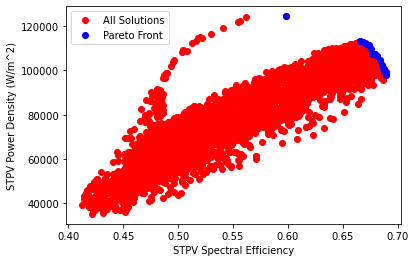

In [24]:
plt.plot(solutions[:,3], solutions[:,4], 'ro', label="All Solutions")
plt.plot(pareto_solutions[:,3],  pareto_solutions[:,4], 'bo', label="Pareto Front")
plt.xlabel("STPV Spectral Efficiency")
plt.ylabel("STPV Power Density (W/m^2)")
plt.legend()
plt.show()

Now we will look at the solution on the Pareto front with the highest value of $\eta$ and the solution with the highest value of $\rho$ and plot the spectrum of both of them.

 Details of the structure that maximizes the STPV Spectral Efficiency
 Thicknesses of layers 2-4: 9.0 261.0 418.0
 Spectral Efficiency (%): 68.95031966169039
 Power Density (W/m^2): 97910.69134366649

 Details of the structure that maximizes the STPV Power Density
 Thicknesses of layers 2-4: 31.0 17.0 0.0
 Spectral Efficiency (%): 59.85639889581
 Power Density (W/m^2): 124392.13908149123


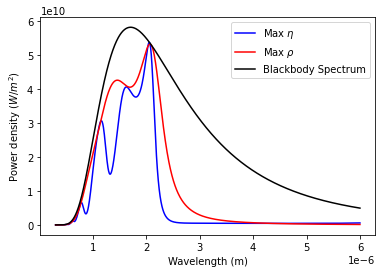

In [32]:
# get the index of the solution with the largest value of \eta
max_eta_index = np.argmax(pareto_solutions[:,3])
# get the index of the solution with the largest value of \rho
max_rho_index = np.argmax(pareto_solutions[:,4])

# update the multilayer with the thicknesses of the solution that maximizes \eta
test.thickness_array[2:5] = pareto_solutions[max_eta_index,:3] * 1e-9
test.compute_stpv()
max_eta_spectrum = test.thermal_emission_array

# get the \eta and \rho values from this structure 
# and double check they match the results in the pareto_solutions array
max_eta_val = test.stpv_spectral_efficiency
rho_val = test.stpv_power_density

assert np.isclose(max_eta_val, pareto_solutions[max_eta_index, 3])
assert np.isclose(rho_val, pareto_solutions[max_eta_index, 4])

print(" Details of the structure that maximizes the STPV Spectral Efficiency")
print(" Thicknesses of layers 2-4:", pareto_solutions[max_eta_index, 0], 
      pareto_solutions[max_eta_index, 1], 
      pareto_solutions[max_eta_index, 2])

print(" Spectral Efficiency (%):", pareto_solutions[max_eta_index, 3] * 100)
print(" Power Density (W/m^2):", pareto_solutions[max_eta_index, 4])

# update the multilayer with the thicknesses of the solution that maximizes \rho
test.thickness_array[2:5] = pareto_solutions[max_rho_index,:3] * 1e-9
test.compute_stpv()
max_rho_spectrum = test.thermal_emission_array

# get the \eta and \rho values from this structure 
# and double check they match the results in the pareto_slutions array
max_rho_val = test.stpv_power_density
eta_val = test.stpv_spectral_efficiency

assert np.isclose(max_rho_val, pareto_solutions[max_rho_index,4])
assert np.isclose(eta_val, pareto_solutions[max_rho_index, 3])

print("\n Details of the structure that maximizes the STPV Power Density")
print(" Thicknesses of layers 2-4:", pareto_solutions[max_rho_index, 0], 
      pareto_solutions[max_rho_index, 1], 
      pareto_solutions[max_rho_index, 2])

print(" Spectral Efficiency (%):", pareto_solutions[max_rho_index, 3] * 100)
print(" Power Density (W/m^2):", pareto_solutions[max_rho_index, 4])


plt.plot(test.wavelength_array, max_eta_spectrum, 'blue', label=r"Max $\eta$")
plt.plot(test.wavelength_array, max_rho_spectrum, 'red', label=r"Max $\rho$")
plt.plot(test.wavelength_array, test.blackbody_spectrum, 'black', label="Blackbody Spectrum")
plt.ylabel(r"Power density ($W/m^2$)")
plt.xlabel(r"Wavelength (m)")
plt.legend()
plt.show()


